In [1]:
import pandas as pd
file_path='train.csv'
df = pd.read_csv(file_path, skip_blank_lines = True)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [2]:
df.shape

(159571, 8)

In [3]:
#deletes id column
del df['id']

#creates new column with the sum of toxicity columns
df['isToxic'] = df['toxic'] + df['severe_toxic'] + df['obscene'] + df['threat'] + df['insult'] + df['identity_hate']

#deletes all the toxicity columns, except the new one created previously 
df.drop(['toxic', 'severe_toxic','obscene','threat','insult','identity_hate'], axis=1,inplace=True)

#the value in isToxic is changed to 1 if its greater than 0
df.loc[df["isToxic"] > 0, "isToxic"] = 1

#now for each comment_text, we have 1 if its toxic in anyway, and 0 for not toxic
df.head(15)


,comment_text,isToxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [4]:
#this can take up to 30 minutes
import re
import string
from nltk.corpus import stopwords
def pre_process(text):
    #removes unnecesary punctuation for example "!","," and splits the text in characters
    text = [char for char in text if char not in string.punctuation]
    text =''.join(text) #joining characters back into words
    text = re.sub('\w*\d\w*','',text)#removing numbers
    #removing stop words and turning each word to lowercase
    to_return = ''
    for word in text.split():
        word = word.lower()
        if word not in stopwords.words('english'):
             to_return += word + " "
    return to_return

df['comment_text'] = df['comment_text'].apply(pre_process)

In [5]:
df.head()

,comment_text,isToxic
0,explanation edits made username hardcore metal...,0
1,daww matches background colour im seemingly st...,0
2,hey man im really trying edit war guy constant...,0
3,cant make real suggestions improvement wondere...,0
4,sir hero chance remember page thats,0


In [6]:
import seaborn as sns

/Users/bilal/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


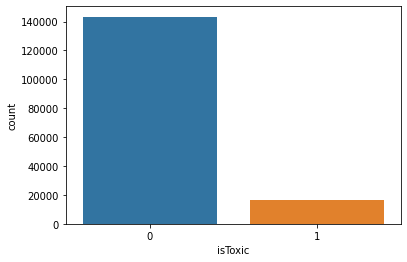

In [8]:
sns.countplot(df['isToxic'])

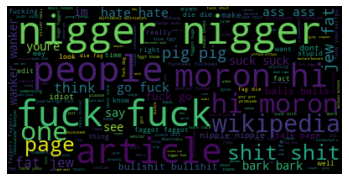

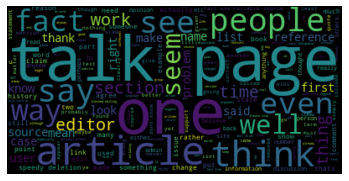

In [10]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#filter the df to one class, and create a list of responses from them
toxicText = df[df.isToxic== 1].comment_text.tolist() 
notoxicText = df[df.isToxic== 0].comment_text.tolist() 

# join the list and lowercase all the words
toxicText = ' '.join(toxicText).lower()
notoxicText = ' '.join(notoxicText).lower()

#create the wordcloud objects
toxicCloud = WordCloud(collocations=True).generate(toxicText)
notoxicCloud = WordCloud(collocations=True).generate(notoxicText)

#plot the wordcloud objects
plt.imshow(toxicCloud, interpolation='bilInear')
plt.axis('off')
plt.show()

plt.imshow(notoxicCloud, interpolation='bilInear')
plt.axis('off')
plt.show()

In [11]:
#makes a new csv file with the changes done
df.to_csv('training_cleaned.csv',columns=['comment_text','isToxic'],index=False)

In [12]:
data = pd.read_csv("training_cleaned.csv")

In [13]:
#This will split the dataset, so we will have 75% training set and 25%  test set randomised
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data.comment_text, data.isToxic, random_state=50)

In [14]:
print(x_test)

69897                                  flag german reich – 
107166    two things one worrying lead finish discussion...
36430     point appears whatever reason either unable si...
37951     weeping frenchman question note justify change...
142842    kfps rfa thanks thank supporting recent nomina...
                                ...                        
3780      ohhhhhh new stuff ohhhhh please phone ok love ...
104291    also anyone able put together page comparing f...
69948                           one wikilinks wpegg — talk 
18212                       august utc ha ha called friend 
55104     explicit reason haredi judaism sounds like jud...
Name: comment_text, Length: 39893, dtype: object


In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
#function that takes ngram_range for countvectorizer and trains then get test results of the model
def get_ngram_results_lr(num1=1,num2=1,model=LogisticRegression()):
    vect = CountVectorizer(ngram_range=(num1, num2)).fit(x_train) #feature extraction
    X_train = vect.transform(x_train)
    model.fit(X_train, y_train) #logistic regression training
    predictionResults = model.predict(vect.transform(x_test)) #prediction results on the testing data
    return predictionResults

In [127]:
#This can take upto 15 minutes to finish
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
for x in range(1,6):
    print("________________________________")
    print("Getting results for ngrams: ",x,",",x)
    results = get_ngram_results_lr(x,x) #passes ngram 1 to 5 
    accuracy =  accuracy_score(results,y_test)
    print(accuracy)
    print("________________________________")

________________________________
Getting results for ngrams:  1 , 1


/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9495901536610433
________________________________
________________________________
Getting results for ngrams:  2 , 2


/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9144210763793147
________________________________
________________________________
Getting results for ngrams:  3 , 3


/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.90050886120372
________________________________
________________________________
Getting results for ngrams:  4 , 4


/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8980522898754167
________________________________
________________________________
Getting results for ngrams:  5 , 5


/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8997067154638658
________________________________


In [126]:
#This can take upto 15 minutes to finish
for x in range(1,6):
    print("________________________________")
    print("Getting results for ngrams: 1 ,",x)
    results = get_ngram_results_lr(1,x)         #passing ngram range 1 and 1to5
    accuracy =  accuracy_score(results,y_test)
    print(accuracy)
    print("________________________________")

________________________________
Getting results for ngrams: 1 , 1


/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9495901536610433
________________________________
________________________________
Getting results for ngrams: 1 , 2


/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9550046374050585
________________________________
________________________________
Getting results for ngrams: 1 , 3


/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9544280951545384
________________________________
________________________________
Getting results for ngrams: 1 , 4


/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9499661594765999
________________________________
________________________________
Getting results for ngrams: 1 , 5


/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9527736695660893
________________________________


In [16]:
corpus = ['This is an example']
vectorizer = CountVectorizer( ngram_range=(1, 2))
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names()

['an', 'an example', 'example', 'is', 'is an', 'this', 'this is']

In [17]:
vect = CountVectorizer(ngram_range=(1, 2)).fit(x_train.values.astype('U')) 
X_train = vect.transform(x_train.values.astype('U'))
model = LogisticRegression()
model.fit(X_train, y_train)

/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/bilal/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

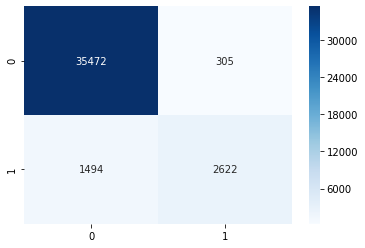

In [18]:
from sklearn.metrics import confusion_matrix
predictionResults = model.predict(vect.transform(x_test.values.astype('U')))
cm = confusion_matrix(y_test, predictionResults)
sns.heatmap(cm,annot=True,cmap='Blues', fmt='g')

In [19]:
from sklearn.metrics import classification_report
target_names = ['notToxic-0', 'isToxic-1']
print(classification_report(y_test,predictionResults, target_names=target_names))

              precision    recall  f1-score   support

  notToxic-0       0.96      0.99      0.98     35777
   isToxic-1       0.90      0.64      0.74      4116

    accuracy                           0.95     39893
   macro avg       0.93      0.81      0.86     39893
weighted avg       0.95      0.95      0.95     39893



In [20]:
def isToxic_category_lr(text):
    test = vect.transform([text])
    predict = model.predict(test)
    if predict == 1:
        return "The text is toxic"
    else:
        return "The text is not Toxic"

In [21]:
print("Type your message to test for toxicity: ")
print()
userText = input()
isToxic_category_lr(pre_process(userText))

Type your message to test for toxicity: 

is this toxic


'The text is not Toxic'